# Using Decision Tree & Naive Bayes to classify Legendary Pokemon

## Import libraries

In [1]:
import gc
import random
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_profiling as pdp
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
import utils as ut
import decisionTree as dt
import naiveBayes as nb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [82]:
# Set packages options
# np.set_printoptions(threshold=np.nan)
# pd.set_option("display.max_columns", 600)
plt.rcParams["figure.figsize"] = (11, 6)

## Define constants and functions

In [115]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

# DropColumns = ["Pokedex#", "Name", "Type 1", "Type 2", "Generation", "Ability 1", "Ability 2", "Ability 3", 
#                "EggGroup 1", "EggGroup 2", "Category", "Height (m)", "Weight (kg)"]

DropColumns = ["Pokedex#", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getDistinctValues(dataFrame, columnName, sep):
    result = []
    for value in dataFrame[columnName].value_counts().index:
        result += value.split(sep)
    return set(result)

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

## Load the data from file

In [3]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes)
data.head()

,Generation,Pokedex#,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
0,1.0,1.0,Bulbasaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,45.0,49.0,49.0,65.0,65.0,45.0,318,Ordinary
1,1.0,2.0,Ivysaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,60.0,62.0,63.0,80.0,80.0,60.0,405,Ordinary
2,6.0,3.0,Mega Venusaur,Seed Pokemon,Grass,Poison,Thick Fat,None,None,87.5,...,Monster,Grass,80.0,100.0,123.0,122.0,120.0,80.0,625,Ordinary
3,1.0,3.0,Venusaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,80.0,82.0,83.0,100.0,100.0,80.0,525,Ordinary
4,1.0,4.0,Charmander,Lizard Pokemon,Fire,None,Blaze,Solar Power,None,87.5,...,Monster,Dragon,39.0,52.0,43.0,60.0,50.0,65.0,309,Ordinary


## Plot graphs to visualize and understand the data

In [ ]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = r["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")

In [ ]:
# Box plot Total & Group
data.boxplot("Total", "Group")

<p> According to the boxplot above, we can see that despite having a small quanity in size, Legendary Pokemon has the highest Total stats compared to the other 2 groups.</p>

## Training & Test Data

In [ ]:
target = "Group"
labels = data[target].unique()
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)
reducedData = r.drop(DropColumns, axis=1)
training, test = ut.splitData(target, reducedData, 0.60)

## Decision Tree

In [ ]:
dtree = dt.DecisionTree(target, 4)
dtree.train(training)
dtPred = dtree.classify(test.drop([target], axis=1))

In [ ]:
dtMatrix = ut.buildConfusionMatrix(dtPred, test[target], reducedData[target].unique())
dtPrecisions, dtRecalls = ut.getPrecisionsAndRecalls(dtMatrix, reducedData[target].unique())
dtFScores = ut.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ut.computeError(dtPred, test["Group"]) * 100)

In [ ]:
treeDepths = [i for i in range(10)]
depthErrors = []
for depth in treeDepths:
    learner = dt.DecisionTree(target, depth)
    learner.train(training)
    pred = learner.classify(test.drop([target], axis=1))
    err = ut.computeError(pred, test["Group"])
    depthErrors.append(err)

Text(0, 0.5, 'Error Rate')

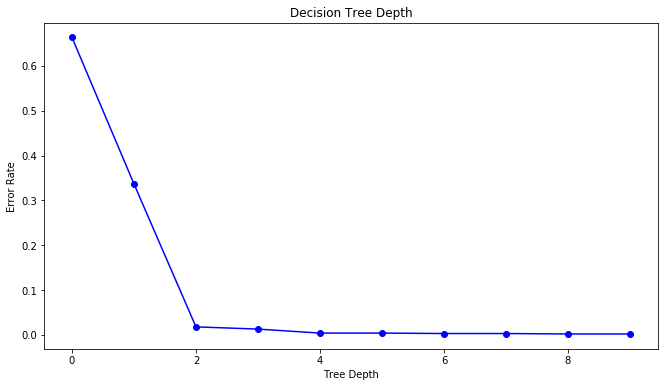

In [194]:
plt.plot(treeDepths, depthErrors, 'bo-')
plt.title("Decision Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")

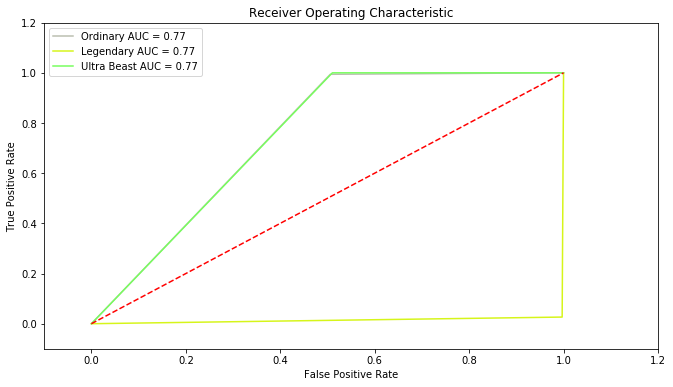

In [128]:
for label in labels:
    c = getRandomColor()
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in dtPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, roc_auc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
kErrors = ut.kFoldCrossValidationResult(10, target, training, dtree)

Text(0, 0.5, 'Mean Error Rate')

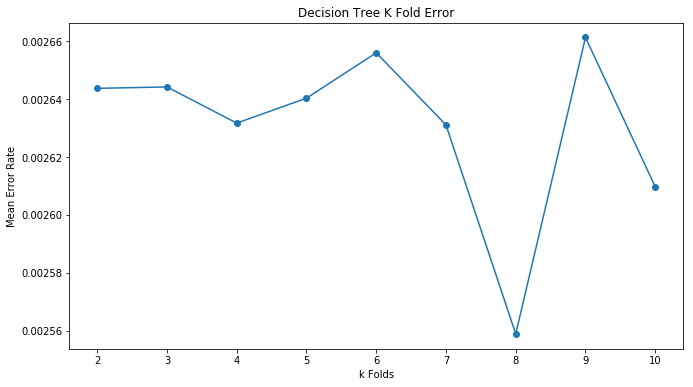

In [187]:
means = [sum(e) / len(e) for e in kErrors]
plt.plot([i for i in range(2, 11)], means, "o-")
plt.title("Decision Tree K Fold Error")
plt.xlabel("k Folds")
plt.ylabel("Mean Error Rate")

### Naive Bayes

In [ ]:
nBayes = nb.NaiveBayes(target, labels)
nBayes.train(training)
nbPred = nBayes.classify(test.drop([target], axis=1))

In [ ]:
nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
nbPrecisions, nbRecalls = ut.getPrecisionsAndRecalls(nbMatrix, reducedData[target].unique())
nbFScores = ut.computeFScores(nbPrecisions, nbRecalls)
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
"Error: {0:.2f}%".format(ut.computeError(nbPred, test["Group"]) * 100)

In [ ]:
nbkErrors = ut.kFoldCrossValidationResult(10, target, training, nBayes)

Text(0, 0.5, 'Mean Error Rate')

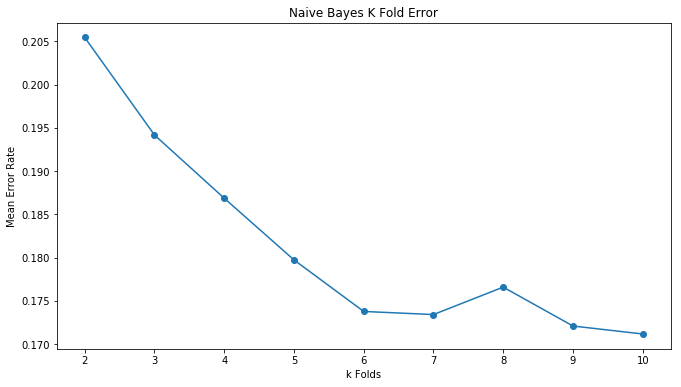

In [186]:
means = [sum(e) / len(e) for e in nbkErrors]
plt.plot([i for i in range(2, 11)], means, "o-")
plt.title("Naive Bayes K Fold Error")
plt.xlabel("k Folds")
plt.ylabel("Mean Error Rate")

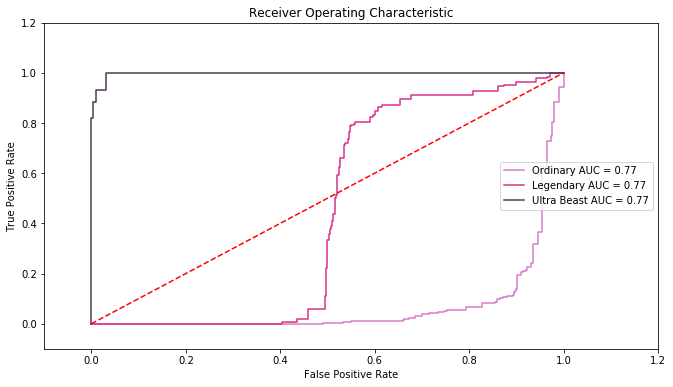

In [188]:
for label in labels:
    c = getRandomColor()
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in nbPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, roc_auc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluation Metric

In [ ]:
k = 10
nBayes = nb.NaiveBayes(target)
sens = []
specs = []

for i in range(k):
    training, test = ut.splitData(target, reducedData, 0.60)    
    nBayes.train(training, reducedData[target].unique())
    nbPred = nBayes.classify(test.drop([target], axis=1))
    
    nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
    nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
    
    sens.append(nbSens)
    specs.append(nbSpec)

In [ ]:
ordinarySens = [sens[i]["Ordinary"] for i in range(k)]
ordinarySpecs = sorted([specs[i]["Ordinary"] for i in range(k)])

In [ ]:
t = "Legendary"
s = sorted([(sens[i][t], specs[i][t]) for i in range(k)], key=lambda x: x[1])

In [ ]:
plt.plot(list(map(lambda x: 1- x, [i[1] for i in s])), [i[0] for i in s], 'bo-', label="Ordinary ROC Curve")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivy")
plt.legend(loc="best")

In [47]:
from sklearn.metrics import roc_curve, auc

In [ ]:
training, test = ut.splitData(target, reducedData, 0.60)    
nBayes.train(training, reducedData[target].unique())
nbPred = nBayes.classify(test.drop([target], axis=1))

nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())

In [ ]:
p = list(map(lambda x: 1 if x == "Ordinary" else 0, nbPred.values))
a = list(map(lambda x: 1 if x == "Ordinary" else 0, test["Group"]))

false_positive_rate, true_positive_rate, thresholds = roc_curve(a, p)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

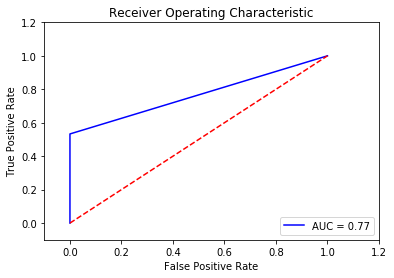

In [51]:
p = [] 

for v in nbPred.sort_index().values:
    if v[0] != "Legendary":
        p.append(0)
    else:
        p.append(v[1])

t = [v for v in test["Group"].sort_index().values]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true=t, y_score=p, pos_label="Legendary")
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# ut.computeError(dtPred, test["Group"])
roc_curve(y_true=t, y_score=p, pos_label="Ordinary")
# dtPred.values
# p

### Playground

In [73]:
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)

Ultra Beast 836
Legendary 855


In [74]:
r[target].value_counts()

Legendary      855
Ultra Beast    836
Ordinary       833
Name: Group, dtype: int64

### Plot Error Rate

In [ ]:
def plotPrecisionRecall(precisions, recalls):
    assert len(precisions) == len(recalls), "Length of precisions and recalls must match"
    assert precisions.keys() == recalls.keys(), "Keys in precisions and recalls must match"
    
    for label in precisions.keys():
        pValue = precisions[label]
        rValue = recalls[label]
        

In [ ]:
ratios = [0.2, 0.4, 0.6, 0.8]
dt = DecisionTree("Group")
x = []
y = []

for ratio in ratios:
    print("************ Split ratio: ", ratio)
    training, test = splitData(data, ratio)
    node = dt.train(training)
    predictions = dt.classify(test, node)
    error = computeError(predictions, test[dt.targetFeature])
    
    x.append(len(training))
    y.append(error)

In [ ]:
plt.plot(x, y, 'bo-', label="With categorical and continuous features")
plt.xlabel("Trainging Set size")
plt.ylabel("Error Rate")
plt.legend(loc="best")

In [ ]:
# Get data profile
profile = pdp.ProfileReport(dataWithDummies)
profile.to_file("Profile.html")
profile = None
gc.collect()